In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import celerite
from celerite import terms

In [65]:
parameter_vector = np.loadtxt('parameter_vector.txt')

In [66]:
nterms = len(parameter_vector)//3

kernel = terms.SHOTerm(log_S0=0, log_omega0=0, log_Q=0) 

for term in range(nterms-1): 
    
    kernel += terms.SHOTerm(log_S0=0, log_omega0=0, log_Q=0)

3098.3139544717865


[Text(0,0.5,'Power'), Text(0.5,0,'$\\mu$Hz')]

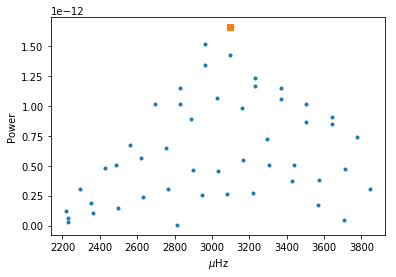

In [101]:
tunable_amps = np.exp(parameter_vector[::3][2:])
tunable_freqs = np.exp(parameter_vector[2::3][2:]) * 1e6/2/np.pi

peak_ind = np.argmax(tunable_amps)
peak_freq = tunable_freqs[peak_ind]
delta_freqs = tunable_freqs - peak_freq

plt.plot(tunable_freqs, tunable_amps, '.')
plt.plot(peak_freq, tunable_amps[peak_ind], 's')
print(peak_freq)
plt.gca().set(xlabel='$\mu$Hz', ylabel='Power')


From Kjeldsen & Bedding (1995) and Huber et al. (2011): 

$$ \nu_\textrm{max} \approx \frac{M / M_\odot (T_\textrm{eff}/T_{\textrm{eff},\odot})^{3.5} }{L/L_\odot} \nu_{\textrm{max}, \odot} $$

$$ \Delta \nu_\textrm{max} \approx \frac{(M / M_\odot)^{0.5} (T_\textrm{eff}/T_{\textrm{eff},\odot})^{3} }{(L/L_\odot)^{0.75}} \Delta \nu_{\odot} $$

In [120]:
peak_freq

3098.3139544717865

In [111]:
import astropy.units as u
from astropy.constants import L_sun, M_sun

T_eff_solar = 5777 * u.K 
nu_max_sun = peak_freq * u.uHz
delta_nu_sun = 135.1 * u.uHz

# # TRAPPIST-1: 
# M = 0.0802 * M_sun
# T_eff = 2511 * u.K
# L = 0.000524 * L_sun

# Kepler-62 (Borucki 2013): 
M = 0.69 * M_sun
T_eff = 4925 * u.K
L = 0.21 * L_sun

nu_max = ( (M/M_sun) * (T_eff/T_eff_solar)**3.5 / (L/L_sun) ) * nu_max_sun
delta_nu_max = ( (M/M_sun)**0.5 * (T_eff/T_eff_solar)**3 / (L/L_sun)**0.75 ) * delta_nu_sun

nu_max, delta_nu_max

(<Quantity 5823.96497599 uHz>, <Quantity 224.14395214 uHz>)

In [112]:
nu_factor = nu_max / nu_max_sun
delta_nu_factor = delta_nu_max / delta_nu_sun

nu_factor, delta_nu_factor

new_peak_freq = nu_factor * peak_freq
new_delta_freqs = delta_freqs * delta_nu_factor

new_peak_freq, new_delta_freqs
new_freqs = new_peak_freq + new_delta_freqs

new_log_omegas = np.log(2*np.pi*new_freqs*1e-6).value

parameter_vector[2::3][2:] = new_log_omegas

In [113]:
kernel.set_parameter_vector(parameter_vector)

In [114]:
gp = celerite.GP(kernel)

# Naturally at 1 second cadence, skip to one minute cadence : 
x = np.arange(0, 1e6, 60) 
gp.compute(x, check_sorted=False)

y = gp.sample(500)

In [115]:
y_concatenated = []

for i, yi in enumerate(y): 
    xi = np.arange(len(yi))
    fit = np.polyval(np.polyfit(xi - xi.mean(), yi, 1), xi-xi.mean())
    yi -= fit
    
    if i == 0: 
        y_concatenated.append(yi)
    else: 
        offset = yi[0] - y_concatenated[i-1][-1]
        y_concatenated.append(yi - offset)
y_concatenated = np.hstack(y_concatenated)

Text(0,0.5,'Flux [ppm]')

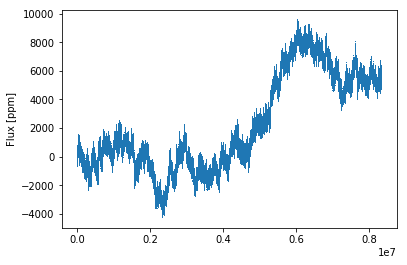

In [116]:
plt.plot(1e6 * y_concatenated, ',')
plt.ylabel('Flux [ppm]')

(0.01, 1000000.0)

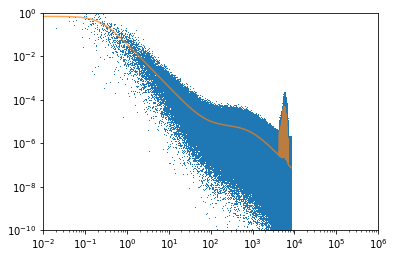

In [117]:
from scipy.signal import periodogram

ftest, Ptest = periodogram(y_concatenated, fs=1/60)

plt.loglog(ftest * 1e6, Ptest, ',')
plt.loglog(ftest * 1e6, 2*np.pi*kernel.get_psd(2*np.pi*ftest), alpha=0.7)
plt.ylim([1e-10, 1e0])
# plt.ylim([1e-8, 1e-5])
plt.xlim([1e-2, 1e6])
# plt.xlim([2000, 4000])